In [1]:
import torch
from torchvision import transforms, datasets

In [2]:
dataset = datasets.ImageFolder(root='../数据集/Google dataset of SIRI-WHU_earth_im_tiff/12class_tif')

In [4]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import os
from torchvision import datasets, models, transforms

In [5]:
pretrained_net = models.resnet18(pretrained=True)
pretrained_net.fc = nn.Linear(512, 2)
PATH = "./my_model/hotdog_fine-tune.pt"
pretrained_net.load_state_dict(torch.load(PATH))
pretrained_net = pretrained_net.eval()

In [7]:
# 预处理
# 指定RGB三个通道的均值和方差来将图像通道归一化
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
test_augs = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize
    ])

In [24]:
pretrained_net = pretrained_net.to('cpu')
# remove the final fc layer
pretrained_net.fc = nn.Sequential()

In [41]:
pretrained_net = pretrained_net.to(device)
def load_query_image(img):
#     query_image = datasets.folder.default_loader(img_path)
    query_image = test_augs(img)
    query_image = query_image.view(-1,3,224,224) # 3,224,224 是预设的 要输入给网络的
    return query_image

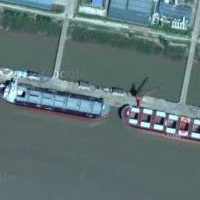

In [43]:
dataset[500][0]

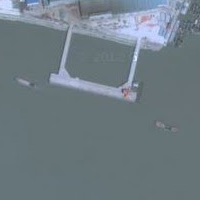

In [55]:
dataset[501][0]

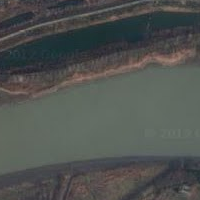

In [47]:
dataset[2100][0]

In [53]:
port1 = load_query_image(dataset[500][0])
port2 = load_query_image(dataset[501][0])
river1 = load_query_image(dataset[2100][0])
similarity_of_two(port1, port2)

tensor(0.7379)

In [54]:
similarity_of_two(port1, river1)

tensor(0.6986)

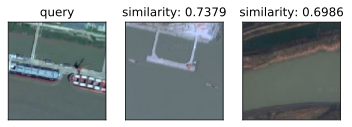

In [59]:
import matplotlib.pyplot as plt
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

transform = transforms.Compose([
            transforms.Resize(size=256),
            transforms.CenterCrop(size=224)
             ])
X = []
X.append(transform(dataset[500][0]))
X.append(transform(dataset[501][0]))
X.append(transform(dataset[2100][0]))
scores = ['query','similarity: 0.7379','similarity: 0.6986']
d2l.use_svg_display()
# 这里的_表示我们忽略（不使用）的变量
_, axes = plt.subplots(nrows = 1, ncols = 3)
#     for f, img, lbl in zip(figs, images, labels):
for i in range(3):
    axes[i].imshow(X[i])
    axes[i].set_title(scores[i])
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)
plt.show()

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def similarity_of_two(img1, img2):
    # 加载到gpu
    img1 = img1.to(device)
    img2 = img2.to(device)
    # 提取特征（1,3,224,224）=> (1,512)
    output_img1 = pretrained_net(img1)
    output_img2 = pretrained_net(img2)
    # (1,512) => (512)
    output_img1 = output_img1.view(512)
    output_img2 = output_img2.view(512)
    output_img1 = output_img1.data.cpu()
    output_img2 = output_img2.data.cpu()
    out = (output_img1*output_img2)/(torch.norm(output_img1,p=2,dim=0, keepdim=True)*torch.norm(output_img2,p=2,dim=0, keepdim=True))
    return out.sum()

In [27]:
similarity_of_two(output1, output2)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got 2-dimensional input of size [1, 512] instead